# Detecting Topic Shifts in Conversations with Semantic Analysis

This notebook aims to detect topic shifts in conversations through semantic analysis. By utilizing vector embeddings, we can perceive subtle changes in semantic similarity, which helps identify potential shifts in conversation topics.

In [ ]:
!pip install cohere sklearn matplotlib seaborn

### Embedding Model

We will use cohere's recent `embed-english-v3.0` model for generating the embeddings

In [192]:
import os
import cohere


co = cohere.Client(os.environ.get("COHERE_API_KEY"))


def embed_documents(documents: list[str]) -> list[list[float]]:
    emb = co.embed(
        documents,
        input_type="search_document",
        model="embed-english-v3.0",
    ).embeddings
    return emb

### Confusion Matrix

In [ ]:
convo = [
    "User: Hi there! Can you tell me the current temperature?",
    "Bot: Hello! It's currently 68°F.",
    "User: That's quite pleasant. I'm thinking of going for a run.",
    "Bot: That sounds like a great idea. Do you need any running tips?",
    "User: Yes, how can I improve my stamina?",
    "Bot: There are several ways to improve stamina, including interval training and cross-training.",
    "User: Thanks for the advice! By the way, do you have any book recommendations?",
    "Bot: Sure, what genre are you interested in?",
    "User: I enjoy mystery novels.",
    "Bot: I would recommend 'The Girl with the Dragon Tattoo' by Stieg Larsson.",
    "User: Sounds interesting, I'll check it out. I also need some advice on home gardening.",
    "Bot: Of course, what do you need help with?",
    "User: I'm having trouble growing tomatoes.",
    "Bot: Tomato plants need plenty of sunlight and well-drained soil. Also, make sure you're watering them correctly.",
    "User: I'll keep that in mind. Thanks for your help!",
    "Bot: You're welcome! If you have any other questions, feel free to ask.",
    "User: Will do. Goodbye for now!",
    "Bot: Goodbye! Have a great day!"
]

Looking at the conversation above, we can observe several topic changes. The discussion transitions from asking about the current temperature in the first two messages and then to running tips between the third and sixth messages. From the seventh message, the topic then shifts to book recommendations, and continues to evolve, covering topics like home gardening.

Let's construct a confusion matrix to see if we notice any drops in similarity when there is a topic 
change


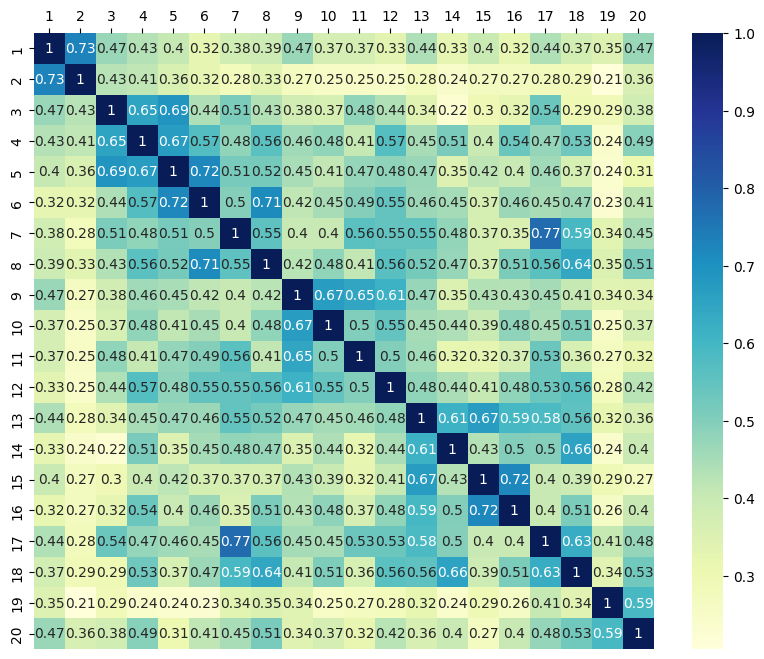

In [104]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt


embeddings = embed_documents(convo)
similarity_matrix = cosine_similarity(embeddings)

plt.figure(figsize=(10, 8))
ax = sns.heatmap(
    similarity_matrix,
    annot=True,
    cmap="YlGnBu",
    xticklabels=range(1, len(convo) + 1),
    yticklabels=range(1, len(convo) + 1),
)
ax.xaxis.tick_top()  # x axis on top
ax.xaxis.set_label_position("top")
# plt.title('Confusion Matrix between Messages')
plt.xlabel('Message Number')
plt.ylabel('Message Number')
plt.show()

We observe that messages 1 and 2 have a high similarity score of 0.73. However, when the topic changes to running tips between messages 2 and 3, the score drops to 0.43. Similarly, messages 3 and 4, 4 and 5, and 5 and 6 have high similarity scores. When the topic shifts to book recommendations at message 7, the similarity score between messages 6 and 7 droped to 0.5. We can leverage these changes to segment the conversation into different topics.


### Segment Conversation Based on Topic Shifts


#### Approach 1:

In this approach, we segment the conversation based on the similarity scores between consecutive messages. We assume that a significant decrease in similarity score beyond a set threshold between consecutive messages indicates a potential topic change.

In [113]:
embeddings = embed_documents(convo)
similarity_matrix = cosine_similarity(embeddings)


threshold = 0.48

for i, sentence in enumerate(convo, start=1):
    print(sentence)
    # check whether similarity between two consecutive messeges are below the threshold
    if i < len(similarity_matrix) and similarity_matrix[i - 1][i] < threshold:
        print("-" * 100)

User: Good morning! How's the weather today?
Bot: Good morning! The weather is sunny with a high of 75°F.
----------------------------------------------------------------------------------------------------
User: That sounds perfect for a day out! I'm planning a picnic.
Bot: Picnics are wonderful. Do you need any picnic basket suggestions?
User: Yes, I'd love some ideas for a vegan picnic.
Bot: Absolutely, I can provide some delicious vegan recipes.
User: That would be fantastic, thank you!
Bot: You're welcome! I'll share some recipes shortly.
----------------------------------------------------------------------------------------------------
User: By the way, have you watched any good movies lately?
Bot: Yes, I recently watched a gripping thriller. Would you like a recommendation?
User: Sure, I'm always up for a good movie!
Bot: I'll suggest a few that you might enjoy.
----------------------------------------------------------------------------------------------------
User: Thanks! Oh

It's not perfect, but we're getting there at spotting topic changes. Let's write a function to handle this, visualize the results, and run more tests.

In [142]:
def segment_by_similarity_drop(messages: list[str], threshold=0.55):
    num_sentences = len(messages)
    segments = {}
    start_index = 0
    topic_number = 1

    convo_emb = embed_documents(documents=messages)
    similarity_matrix = cosine_similarity(convo_emb)

    for i in range(1, num_sentences):
        if (
            i < len(similarity_matrix) and similarity_matrix[i - 1][i] < threshold
        ):  # Detect topic change
            segments[f"topic {topic_number}"] = messages[start_index:i]
            start_index = i
            topic_number += 1

    segments[f"topic {topic_number}"] = messages[start_index:]  # Add the last chunk
    return segments

In [143]:
segments = segment_by_similarity_drop(messages=convo)
segments

{'topic 1': ["User: Good morning! How's the weather today?",
  'Bot: Good morning! The weather is sunny with a high of 75°F.'],
 'topic 2': ["User: That sounds perfect for a day out! I'm planning a picnic.",
  'Bot: Picnics are wonderful. Do you need any picnic basket suggestions?',
  "User: Yes, I'd love some ideas for a vegan picnic.",
  'Bot: Absolutely, I can provide some delicious vegan recipes.'],
 'topic 3': ['User: That would be fantastic, thank you!',
  "Bot: You're welcome! I'll share some recipes shortly."],
 'topic 4': ['User: By the way, have you watched any good movies lately?',
  'Bot: Yes, I recently watched a gripping thriller. Would you like a recommendation?'],
 'topic 5': ["User: Sure, I'm always up for a good movie!"],
 'topic 6': ["Bot: I'll suggest a few that you might enjoy."],
 'topic 7': ['User: Thanks! Oh, I also need help with my finances.',
  'Bot: Of course, what specifically do you need assistance with?'],
 'topic 8': ["User: I'm looking for advice on sav

Let's print this as a nice table

In [ ]:
!pip install tabulate colorma pandas

In [116]:
from sklearn.metrics.pairwise import cosine_similarity
from colorama import Fore, Style
from tabulate import tabulate
import pandas as pd


def visualize_topic_segments(segments: dict[str, list]):
    colors = [
        Fore.BLUE,
        Fore.GREEN,
        Fore.RED,
        Fore.YELLOW,
        Fore.MAGENTA,
        Fore.CYAN,
        Fore.WHITE,
    ]
    rows = [
        {
            "Topic": colors[i % 7] + segment + Style.RESET_ALL,
            "Message": colors[i % 7] + message + Style.RESET_ALL,
        }
        for i, (segment, messages) in enumerate(segments.items())
        for message in messages
    ]

    df = pd.DataFrame(rows)
    print(tabulate(df, headers="keys", tablefmt="psql"))

In [144]:
visualize_topic_segments(segments)

+----+----------+------------------------------------------------------------------------------------+
|    | Topic    | Message                                                                            |
|----+----------+------------------------------------------------------------------------------------|
|  0 | topic 1  | User: Good morning! How's the weather today?                                       |
|  1 | topic 1  | Bot: Good morning! The weather is sunny with a high of 75°F.                       |
|  2 | topic 2  | User: That sounds perfect for a day out! I'm planning a picnic.                    |
|  3 | topic 2  | Bot: Picnics are wonderful. Do you need any picnic basket suggestions?             |
|  4 | topic 2  | User: Yes, I'd love some ideas for a vegan picnic.                                 |
|  5 | topic 2  | Bot: Absolutely, I can provide some delicious vegan recipes.                       |
|  6 | topic 3  | User: That would be fantastic, thank you!              

Now let's try different threshold levels

In [145]:
segments = segment_by_similarity_drop(messages=convo, threshold=0.7)
visualize_topic_segments(segments)

+----+----------+------------------------------------------------------------------------------------+
|    | Topic    | Message                                                                            |
|----+----------+------------------------------------------------------------------------------------|
|  0 | topic 1  | User: Good morning! How's the weather today?                                       |
|  1 | topic 1  | Bot: Good morning! The weather is sunny with a high of 75°F.                       |
|  2 | topic 2  | User: That sounds perfect for a day out! I'm planning a picnic.                    |
|  3 | topic 3  | Bot: Picnics are wonderful. Do you need any picnic basket suggestions?             |
|  4 | topic 4  | User: Yes, I'd love some ideas for a vegan picnic.                                 |
|  5 | topic 4  | Bot: Absolutely, I can provide some delicious vegan recipes.                       |
|  6 | topic 5  | User: That would be fantastic, thank you!              

In [146]:
segments = segment_by_similarity_drop(messages=convo, threshold=0.4)
visualize_topic_segments(segments)

+----+---------+------------------------------------------------------------------------------------+
|    | Topic   | Message                                                                            |
|----+---------+------------------------------------------------------------------------------------|
|  0 | topic 1 | User: Good morning! How's the weather today?                                       |
|  1 | topic 1 | Bot: Good morning! The weather is sunny with a high of 75°F.                       |
|  2 | topic 1 | User: That sounds perfect for a day out! I'm planning a picnic.                    |
|  3 | topic 1 | Bot: Picnics are wonderful. Do you need any picnic basket suggestions?             |
|  4 | topic 1 | User: Yes, I'd love some ideas for a vegan picnic.                                 |
|  5 | topic 1 | Bot: Absolutely, I can provide some delicious vegan recipes.                       |
|  6 | topic 1 | User: That would be fantastic, thank you!                        

In [147]:
segments = segment_by_similarity_drop(messages=convo, threshold=0.47)
visualize_topic_segments(segments)

+----+---------+------------------------------------------------------------------------------------+
|    | Topic   | Message                                                                            |
|----+---------+------------------------------------------------------------------------------------|
|  0 | topic 1 | User: Good morning! How's the weather today?                                       |
|  1 | topic 1 | Bot: Good morning! The weather is sunny with a high of 75°F.                       |
|  2 | topic 2 | User: That sounds perfect for a day out! I'm planning a picnic.                    |
|  3 | topic 2 | Bot: Picnics are wonderful. Do you need any picnic basket suggestions?             |
|  4 | topic 2 | User: Yes, I'd love some ideas for a vegan picnic.                                 |
|  5 | topic 2 | Bot: Absolutely, I can provide some delicious vegan recipes.                       |
|  6 | topic 2 | User: That would be fantastic, thank you!                        

Let's try few more conversations

In [148]:
convo1 = [
    "User: Hi there! Can you tell me the current temperature?",
    "Bot: Hello! It's currently 68°F.",
    "User: That's quite pleasant. I'm thinking of going for a run.",
    "Bot: That sounds like a great idea. Do you need any running tips?",
    "User: Yes, how can I improve my stamina?",
    "Bot: There are several ways to improve stamina, including interval training and cross-training.",
    "User: Thanks for the advice! By the way, do you have any book recommendations?",
    "Bot: Sure, what genre are you interested in?",
    "User: I enjoy mystery novels.",
    "Bot: I would recommend 'The Girl with the Dragon Tattoo' by Stieg Larsson.",
    "User: Sounds interesting, I'll check it out. I also need some advice on home gardening.",
    "Bot: Of course, what do you need help with?",
    "User: I'm having trouble growing tomatoes.",
    "Bot: Tomato plants need plenty of sunlight and well-drained soil. Also, make sure you're watering them correctly.",
    "User: I'll keep that in mind. Thanks for your help!",
    "Bot: You're welcome! If you have any other questions, feel free to ask.",
    "User: Will do. Goodbye for now!",
    "Bot: Goodbye! Have a great day!"
]

convo2 = [
    "User: Hello! Can you tell me the latest news headlines?",
    "Bot: Hi! Sure, here are the top news headlines for today...",
    "User: That's quite interesting. I'm also looking for some new music to listen to.",
    "Bot: What genre do you prefer?",
    "User: I like pop music.",
    "Bot: You might enjoy the latest album by Dua Lipa.",
    "User: I'll give it a listen. Also, I'm planning a trip and need some travel tips.",
    "Bot: Sure, where are you planning to go?",
    "User: I'm thinking of visiting Italy.",
    "Bot: Italy is a beautiful country. Make sure to visit the Colosseum in Rome and the canals in Venice.",
    "User: Those sound like great suggestions. I also need some help with my diet.",
    "Bot: What kind of diet are you following?",
    "User: I'm trying to eat more protein.",
    "Bot: Include lean meats, eggs, and legumes in your diet for a protein boost.",
    "User: Thanks for the tips! I'll talk to you later.",
    "Bot: You're welcome! Don't hesitate to reach out if you need more help.",
    "User: I appreciate it. Goodbye!",
    "Bot: Goodbye! Take care!"
]

In [155]:
segments = segment_by_similarity_drop(messages=convo1, threshold=0.35)
visualize_topic_segments(segments)

+----+---------+-------------------------------------------------------------------------------------------------------------------+
|    | Topic   | Message                                                                                                           |
|----+---------+-------------------------------------------------------------------------------------------------------------------|
|  0 | topic 1 | User: Hi there! Can you tell me the current temperature?                                                          |
|  1 | topic 1 | Bot: Hello! It's currently 68°F.                                                                                  |
|  2 | topic 2 | User: That's quite pleasant. I'm thinking of going for a run.                                                     |
|  3 | topic 2 | Bot: That sounds like a great idea. Do you need any running tips?                                                 |
|  4 | topic 2 | User: Yes, how can I improve my stamina?            

In [160]:
segments = segment_by_similarity_drop(messages=convo2, threshold=0.47)
visualize_topic_segments(segments)

+----+---------+-------------------------------------------------------------------------------------------------------+
|    | Topic   | Message                                                                                               |
|----+---------+-------------------------------------------------------------------------------------------------------|
|  0 | topic 1 | User: Hello! Can you tell me the latest news headlines?                                               |
|  1 | topic 1 | Bot: Hi! Sure, here are the top news headlines for today...                                           |
|  2 | topic 2 | User: That's quite interesting. I'm also looking for some new music to listen to.                     |
|  3 | topic 3 | Bot: What genre do you prefer?                                                                        |
|  4 | topic 4 | User: I like pop music.                                                                               |
|  5 | topic 4 | Bot: You might 

If we set the threshold too high or too low, the results are not good. A threshold between 0.35 and 0.55 seems to yield better results with this approach. However, one potential issue is the inconsistency in the similarity score drop that identifies a topic change. If we cannot achieve a consistent score that performs well across multiple conversations, it may not be feasible to use semantic changes to detect topic changes in production applications.

#### Approach 2:

In this method, we divide the conversation into segments based on the similarity scores between a sequence of consecutive messages. We create embeddings by concatenating all the messages in the sequence and apply this process across the entire conversation. For instance:
- [0, 1, 2, 3] -> embed
- [1, 2, 3, 4] -> embed
- [2, 3, 4, 5] -> embed

By doing this, we aim to reduce the noise in individual interactions, similar to how a moving average is used to smooth out fluctuations in stock prices.

In [164]:
window_size = 3

for i, _ in enumerate(convo):
    text_window = "\n".join(convo[max(0, i - window_size + 1) : i + 1])
    print(text_window)
    print("-" * 100)

User: Good morning! How's the weather today?
----------------------------------------------------------------------------------------------------
User: Good morning! How's the weather today?
Bot: Good morning! The weather is sunny with a high of 75°F.
----------------------------------------------------------------------------------------------------
User: Good morning! How's the weather today?
Bot: Good morning! The weather is sunny with a high of 75°F.
User: That sounds perfect for a day out! I'm planning a picnic.
----------------------------------------------------------------------------------------------------
Bot: Good morning! The weather is sunny with a high of 75°F.
User: That sounds perfect for a day out! I'm planning a picnic.
Bot: Picnics are wonderful. Do you need any picnic basket suggestions?
----------------------------------------------------------------------------------------------------
User: That sounds perfect for a day out! I'm planning a picnic.
Bot: Picnics ar

In [166]:
def segment_by_similarity_drop(messages: list[str], threshold=0.55, window_size=1):
    num_sentences = len(messages)
    segments = {}
    start_index = 0
    topic_number = 1

    text_windows = [
        "\n".join(messages[max(0, i - window_size + 1) : i + 1])
        for i in range(num_sentences)
    ]
    convo_emb = embed_documents(documents=text_windows)
    similarity_matrix = cosine_similarity(convo_emb)

    for i in range(1, num_sentences):
        if similarity_matrix[i - 1][i] < threshold:  # Detect topic change
            segments[f"topic {topic_number}"] = messages[start_index:i]
            start_index = i
            topic_number += 1

    segments[f"topic {topic_number}"] = messages[start_index:]  # Add the last chunk
    return segments

In [169]:
segments = segment_by_similarity_drop(messages=convo, threshold=0.47, window_size=2)
visualize_topic_segments(segments)

+----+---------+------------------------------------------------------------------------------------+
|    | Topic   | Message                                                                            |
|----+---------+------------------------------------------------------------------------------------|
|  0 | topic 1 | User: Good morning! How's the weather today?                                       |
|  1 | topic 1 | Bot: Good morning! The weather is sunny with a high of 75°F.                       |
|  2 | topic 1 | User: That sounds perfect for a day out! I'm planning a picnic.                    |
|  3 | topic 1 | Bot: Picnics are wonderful. Do you need any picnic basket suggestions?             |
|  4 | topic 1 | User: Yes, I'd love some ideas for a vegan picnic.                                 |
|  5 | topic 1 | Bot: Absolutely, I can provide some delicious vegan recipes.                       |
|  6 | topic 1 | User: That would be fantastic, thank you!                        

In [176]:
segments = segment_by_similarity_drop(messages=convo, threshold=0.77, window_size=2)
visualize_topic_segments(segments)

+----+---------+------------------------------------------------------------------------------------+
|    | Topic   | Message                                                                            |
|----+---------+------------------------------------------------------------------------------------|
|  0 | topic 1 | User: Good morning! How's the weather today?                                       |
|  1 | topic 1 | Bot: Good morning! The weather is sunny with a high of 75°F.                       |
|  2 | topic 1 | User: That sounds perfect for a day out! I'm planning a picnic.                    |
|  3 | topic 2 | Bot: Picnics are wonderful. Do you need any picnic basket suggestions?             |
|  4 | topic 2 | User: Yes, I'd love some ideas for a vegan picnic.                                 |
|  5 | topic 2 | Bot: Absolutely, I can provide some delicious vegan recipes.                       |
|  6 | topic 2 | User: That would be fantastic, thank you!                        

In [177]:
segments = segment_by_similarity_drop(messages=convo, threshold=0.77, window_size=3)
visualize_topic_segments(segments)

+----+---------+------------------------------------------------------------------------------------+
|    | Topic   | Message                                                                            |
|----+---------+------------------------------------------------------------------------------------|
|  0 | topic 1 | User: Good morning! How's the weather today?                                       |
|  1 | topic 1 | Bot: Good morning! The weather is sunny with a high of 75°F.                       |
|  2 | topic 1 | User: That sounds perfect for a day out! I'm planning a picnic.                    |
|  3 | topic 1 | Bot: Picnics are wonderful. Do you need any picnic basket suggestions?             |
|  4 | topic 2 | User: Yes, I'd love some ideas for a vegan picnic.                                 |
|  5 | topic 2 | Bot: Absolutely, I can provide some delicious vegan recipes.                       |
|  6 | topic 2 | User: That would be fantastic, thank you!                        

In [178]:
segments = segment_by_similarity_drop(messages=convo, threshold=0.85, window_size=3)
visualize_topic_segments(segments)

+----+---------+------------------------------------------------------------------------------------+
|    | Topic   | Message                                                                            |
|----+---------+------------------------------------------------------------------------------------|
|  0 | topic 1 | User: Good morning! How's the weather today?                                       |
|  1 | topic 2 | Bot: Good morning! The weather is sunny with a high of 75°F.                       |
|  2 | topic 2 | User: That sounds perfect for a day out! I'm planning a picnic.                    |
|  3 | topic 2 | Bot: Picnics are wonderful. Do you need any picnic basket suggestions?             |
|  4 | topic 3 | User: Yes, I'd love some ideas for a vegan picnic.                                 |
|  5 | topic 3 | Bot: Absolutely, I can provide some delicious vegan recipes.                       |
|  6 | topic 3 | User: That would be fantastic, thank you!                        

In [179]:
segments = segment_by_similarity_drop(messages=convo, threshold=0.75, window_size=3)
visualize_topic_segments(segments)

+----+---------+------------------------------------------------------------------------------------+
|    | Topic   | Message                                                                            |
|----+---------+------------------------------------------------------------------------------------|
|  0 | topic 1 | User: Good morning! How's the weather today?                                       |
|  1 | topic 1 | Bot: Good morning! The weather is sunny with a high of 75°F.                       |
|  2 | topic 1 | User: That sounds perfect for a day out! I'm planning a picnic.                    |
|  3 | topic 1 | Bot: Picnics are wonderful. Do you need any picnic basket suggestions?             |
|  4 | topic 2 | User: Yes, I'd love some ideas for a vegan picnic.                                 |
|  5 | topic 2 | Bot: Absolutely, I can provide some delicious vegan recipes.                       |
|  6 | topic 2 | User: That would be fantastic, thank you!                        

In [184]:
segments = segment_by_similarity_drop(messages=convo1, threshold=0.75, window_size=3)
visualize_topic_segments(segments)

+----+---------+-------------------------------------------------------------------------------------------------------------------+
|    | Topic   | Message                                                                                                           |
|----+---------+-------------------------------------------------------------------------------------------------------------------|
|  0 | topic 1 | User: Hi there! Can you tell me the current temperature?                                                          |
|  1 | topic 1 | Bot: Hello! It's currently 68°F.                                                                                  |
|  2 | topic 1 | User: That's quite pleasant. I'm thinking of going for a run.                                                     |
|  3 | topic 1 | Bot: That sounds like a great idea. Do you need any running tips?                                                 |
|  4 | topic 2 | User: Yes, how can I improve my stamina?            

In [185]:
segments = segment_by_similarity_drop(messages=convo2, threshold=0.75, window_size=3)
visualize_topic_segments(segments)

+----+---------+-------------------------------------------------------------------------------------------------------+
|    | Topic   | Message                                                                                               |
|----+---------+-------------------------------------------------------------------------------------------------------|
|  0 | topic 1 | User: Hello! Can you tell me the latest news headlines?                                               |
|  1 | topic 1 | Bot: Hi! Sure, here are the top news headlines for today...                                           |
|  2 | topic 1 | User: That's quite interesting. I'm also looking for some new music to listen to.                     |
|  3 | topic 1 | Bot: What genre do you prefer?                                                                        |
|  4 | topic 1 | User: I like pop music.                                                                               |
|  5 | topic 1 | Bot: You might 

In [187]:
segments = segment_by_similarity_drop(messages=convo2, threshold=0.83, window_size=3)
visualize_topic_segments(segments)

+----+---------+-------------------------------------------------------------------------------------------------------+
|    | Topic   | Message                                                                                               |
|----+---------+-------------------------------------------------------------------------------------------------------|
|  0 | topic 1 | User: Hello! Can you tell me the latest news headlines?                                               |
|  1 | topic 1 | Bot: Hi! Sure, here are the top news headlines for today...                                           |
|  2 | topic 1 | User: That's quite interesting. I'm also looking for some new music to listen to.                     |
|  3 | topic 1 | Bot: What genre do you prefer?                                                                        |
|  4 | topic 2 | User: I like pop music.                                                                               |
|  5 | topic 2 | Bot: You might 

#### Approach 3

In this approach, we compare the similarity only among sentences within a topic. We start by comparing the first sentence with the next. Then, we combine the first and second sentences and compare their combined similarity with the third sentence. We continue this process until the similarity drops below a certain threshold. This drop signifies a change in the topic.

In [194]:
def segment_by_similarity_drop(messages: list[str], threshold=0.5):
    num_sentences = len(messages)
    chunks = {}
    start_index = 0
    topic_number = 1

    for i in range(1, num_sentences):
        topic_change_detected = False
        conv_i = '\n'.join(messages[start_index:i+1])
        print(conv_i)
        print()
        if i+1 < num_sentences:  # Check if the next index is within the range
            print(messages[i+1])
        print("-"*20)
        convo_emb_i = embed_documents(documents=[conv_i])[0]
        if i+1 < num_sentences:  # Check if the next index is within the range
            convo_emb_next = embed_documents(documents=[messages[i+1]])[0]
        else:
            convo_emb_next = None
        if convo_emb_next and cosine_similarity([convo_emb_i], [convo_emb_next])[0][0] < threshold:
            chunks[f"topic {topic_number}"] = messages[start_index:i+1]
            start_index = i+1
            topic_number += 1
            topic_change_detected = True
        if topic_change_detected:
            continue

    chunks[f"topic {topic_number}"] = messages[start_index:]  # Add the last chunk
    return chunks

In [195]:
splits = segment_by_similarity_drop(convo, threshold=0.45)
visualize_topic_splits(splits)

User: Good morning! How's the weather today?
Bot: Good morning! The weather is sunny with a high of 75°F.

User: That sounds perfect for a day out! I'm planning a picnic.
--------------------
User: That sounds perfect for a day out! I'm planning a picnic.

Bot: Picnics are wonderful. Do you need any picnic basket suggestions?
--------------------
User: That sounds perfect for a day out! I'm planning a picnic.
Bot: Picnics are wonderful. Do you need any picnic basket suggestions?

User: Yes, I'd love some ideas for a vegan picnic.
--------------------
User: That sounds perfect for a day out! I'm planning a picnic.
Bot: Picnics are wonderful. Do you need any picnic basket suggestions?
User: Yes, I'd love some ideas for a vegan picnic.

Bot: Absolutely, I can provide some delicious vegan recipes.
--------------------
User: That sounds perfect for a day out! I'm planning a picnic.
Bot: Picnics are wonderful. Do you need any picnic basket suggestions?
User: Yes, I'd love some ideas for a ve

In [196]:
splits = segment_by_similarity_drop(convo1, threshold=0.45)
visualize_topic_splits(splits)

User: Hi there! Can you tell me the current temperature?
Bot: Hello! It's currently 68°F.

User: That's quite pleasant. I'm thinking of going for a run.
--------------------
User: That's quite pleasant. I'm thinking of going for a run.

Bot: That sounds like a great idea. Do you need any running tips?
--------------------
User: That's quite pleasant. I'm thinking of going for a run.
Bot: That sounds like a great idea. Do you need any running tips?

User: Yes, how can I improve my stamina?
--------------------
User: That's quite pleasant. I'm thinking of going for a run.
Bot: That sounds like a great idea. Do you need any running tips?
User: Yes, how can I improve my stamina?

Bot: There are several ways to improve stamina, including interval training and cross-training.
--------------------
User: That's quite pleasant. I'm thinking of going for a run.
Bot: That sounds like a great idea. Do you need any running tips?
User: Yes, how can I improve my stamina?
Bot: There are several ways t

In [197]:
splits = segment_by_similarity_drop(convo2, threshold=0.45)
visualize_topic_splits(splits)

User: Hello! Can you tell me the latest news headlines?
Bot: Hi! Sure, here are the top news headlines for today...

User: That's quite interesting. I'm also looking for some new music to listen to.
--------------------
User: That's quite interesting. I'm also looking for some new music to listen to.

Bot: What genre do you prefer?
--------------------
Bot: What genre do you prefer?

User: I like pop music.
--------------------
Bot: What genre do you prefer?
User: I like pop music.

Bot: You might enjoy the latest album by Dua Lipa.
--------------------
Bot: What genre do you prefer?
User: I like pop music.
Bot: You might enjoy the latest album by Dua Lipa.

User: I'll give it a listen. Also, I'm planning a trip and need some travel tips.
--------------------
User: I'll give it a listen. Also, I'm planning a trip and need some travel tips.

Bot: Sure, where are you planning to go?
--------------------
User: I'll give it a listen. Also, I'm planning a trip and need some travel tips.
Bot

The results appear to be more consistent with this approach, as we can obtain satisfactory results for the three conversations using a single threshold level of 0.45. However, this method is currently slow due to the iterative computation of the embeddings. We should explore ways to pre-compute all the embeddings and perform the comparison to enhance speed.